# Финальный проект «Телеком»

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [1]:
!pip install phik
!pip install optuna
!pip install shap
!pip install catboost
!pip install lightgbm

In [2]:
import os
from typing import Optional

import catboost
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import pandas as pd
from phik import phik_matrix
from scipy import stats
import seaborn as sns
import shap

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [3]:
RANDOM_STATE = 70823

In [4]:
try:
    contract = pd.read_csv("/datasets/contract_new.csv")
    internet = pd.read_csv("/datasets/internet_new.csv")
    personal = pd.read_csv("/datasets/personal_new.csv")
    phone = pd.read_csv("/datasets/phone_new.csv")
except:
    contract = pd.read_csv("./datasets/final_provider/contract_new.csv")
    internet = pd.read_csv("./datasets/final_provider/internet_new.csv")
    personal = pd.read_csv("./datasets/final_provider/personal_new.csv")
    phone = pd.read_csv("./datasets/final_provider/phone_new.csv")

### Знакомство с данными

#### contract

In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
contract['customerID'].nunique()

7043

In [8]:
pd.to_datetime(contract['BeginDate']).head()

0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: BeginDate, dtype: datetime64[ns]

Дата переводиться без проблем

In [9]:
pd.to_datetime(contract.loc[contract['EndDate'] != 'No', 'EndDate']).head()

9    2017-05-01
15   2016-03-01
25   2018-09-01
30   2018-11-01
35   2018-12-01
Name: EndDate, dtype: datetime64[ns]

Дата переводиться без проблем

In [10]:
contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [11]:
contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [12]:
contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

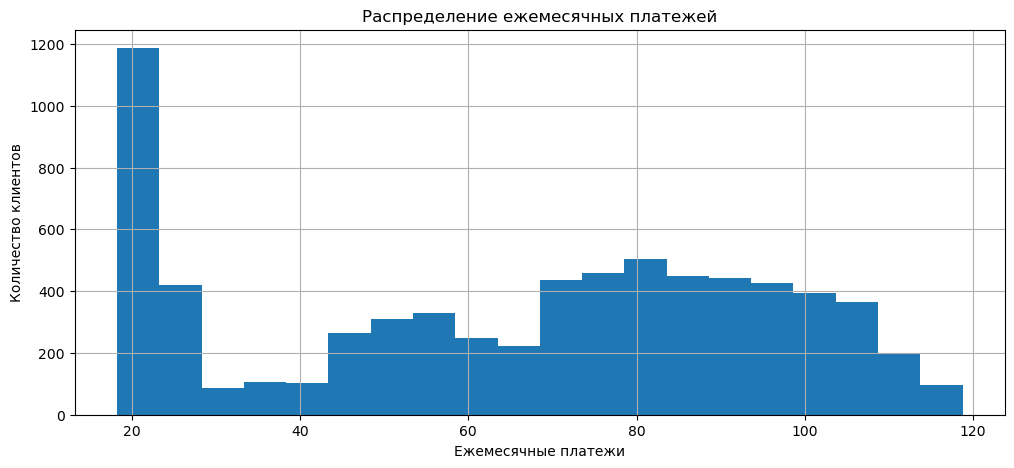

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))

contract['MonthlyCharges'].hist(bins=20, ax=ax)
ax.set_xlabel('MonthlyCharges')
ax.set_title('Распределение ежемесячных платежей') 
ax.set_xlabel('Ежемесячные платежи') 
ax.set_ylabel('Количество клиентов') 
plt.show()

Проверим, переводиться ли во float

In [14]:
contract.loc[contract['TotalCharges'] != ' ', 'TotalCharges'].astype('float').head()

0      31.04
1    2071.84
2     226.17
3    1960.60
4     353.50
Name: TotalCharges, dtype: float64

In [15]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges']

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object

Эти данные можно откинуть

__Вывод__

- В таблице contract содержится 8 полей.
- Уникальные идентификаторы клиентов находятся в поле customerID.
- Поля BeginDate и EndDate содержат информацию о датах. Значение EndDate также может быть обозначено как No.
- Поля Type, PaperlessBilling и PaymentMethod являются категориальными. Поле PaymentMethod также может иметь два возможных значения.
- Поля MonthlyCharges и TotalCharges имеют числовой характер. В поле TotalCharges присутствуют некоторые значения "пробелов", которые могут быть исключены.

#### personal

In [16]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [17]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [18]:
personal['customerID'].nunique()

7043

In [19]:
personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [20]:
personal['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [21]:
personal['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [22]:
personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

__Вывод:__
- В таблице personal представлены 4 поля.
- Уникальные идентификаторы клиентов содержатся в поле customerID.
- Остальные поля обладают бинарным характером.

#### internet

In [23]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [24]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [25]:
internet['customerID'].nunique()

5517

In [26]:
internet['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [27]:
internet['OnlineSecurity'].unique()

array(['No', 'Yes'], dtype=object)

In [28]:
internet['OnlineBackup'].unique()

array(['Yes', 'No'], dtype=object)

In [29]:
internet['DeviceProtection'].unique()

array(['No', 'Yes'], dtype=object)

In [30]:
internet['TechSupport'].unique()

array(['No', 'Yes'], dtype=object)

In [31]:
internet['StreamingTV'].unique()

array(['No', 'Yes'], dtype=object)

In [32]:
internet['StreamingMovies'].unique()

array(['No', 'Yes'], dtype=object)

__Вывод:__
- В таблице internet присутствуют 8 полей.
- Уникальные идентификаторы клиентов содержатся в поле customerID.
- Остальные поля имеют двоичную природу, за исключением поля InternetService, которое имеет три варианта значений.

#### phone

In [33]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [34]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [35]:
phone['customerID'].nunique()

6361

In [36]:
phone['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

__Вывод:__
- В таблице phone имеются всего 2 поля.
- Поле customerID содержит уникальные идентификаторы клиентов.
- Второе поле, MultipleLines, имеет двоичную природу.

### Предварительная обработка данных

Удаляем проблемные строчки

In [37]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = contract['MonthlyCharges']
contract['TotalCharges'] = contract['TotalCharges'].astype('float')


Формируем целевую переменную

In [38]:
contract['target'] = contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

Формируем признак продолжительности контракта

In [39]:
contract['EndDate'] = contract['EndDate'].replace({'No': '2020-02-01'})

In [40]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'])
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['duration'] = (contract['EndDate'] - contract['BeginDate']).dt.days
contract = contract.drop(columns=['BeginDate', 'EndDate'])

In [41]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('object')

Собираем всё вместе

In [42]:
data = contract.merge(personal, how='left', on='customerID')
data = data.merge(internet, how='left', on='customerID')
data = data.merge(phone, how='left', on='customerID')
data = data.set_index('customerID')

Заполним пропуски заглушкой для CatBoost

In [43]:
data = data.fillna('NotUsed')

In [44]:
df = data

Приведём колонки к категориальному типу для LightGBM

In [45]:
data[data.select_dtypes(['object']).columns] = data.select_dtypes(['object']).apply(lambda x: x.astype('category'))

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7043 non-null   category
 1   PaperlessBilling  7043 non-null   category
 2   PaymentMethod     7043 non-null   category
 3   MonthlyCharges    7043 non-null   float64 
 4   TotalCharges      7043 non-null   float64 
 5   target            7043 non-null   int64   
 6   duration          7043 non-null   int64   
 7   gender            7043 non-null   category
 8   SeniorCitizen     7043 non-null   int64   
 9   Partner           7043 non-null   category
 10  Dependents        7043 non-null   category
 11  InternetService   7043 non-null   category
 12  OnlineSecurity    7043 non-null   category
 13  OnlineBackup      7043 non-null   category
 14  DeviceProtection  7043 non-null   category
 15  TechSupport       7043 non-null   category
 16  StreamingTV   

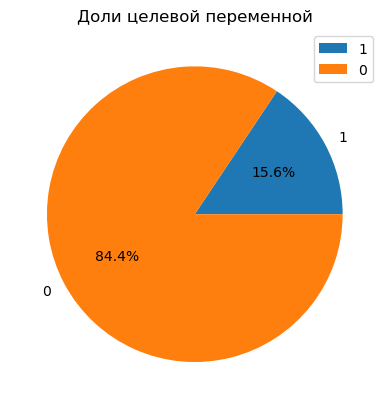

In [46]:
fig, ax = plt.subplots()

ax.pie([data['target'].mean(), 1 - data['target'].mean()], labels=['1', '0'], autopct='%1.1f%%')
ax.legend()
ax.set_title('Доли целевой переменной')

plt.show()

Наблюдается дисбаланс классов с перевесом в пользу действующих договоров. Дисбаланс учтем при оучении моделей.

In [47]:
def violinplot_denshist_ttest(df: pd.DataFrame, feature: str,target: str,) -> None:
    """
    Визуализирует разницу в распределениях численного непрерывного признака между классами целевого бинарного признака.
    """
    df = df[[feature, target]].copy()
    if df[feature].dtype != 'float':
        df[feature] = df[feature].astype('float')

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Violinplot
    sns.violinplot(
        data=df,
        x=target,
        y=feature,
        ax=axes[0],
    )
    axes[0].set_title('Violinplot')

    sns.histplot(
        data=df,
        x=feature,
        hue=target,
        bins=20,
        stat='density',
        common_norm=False,
#         element='step',
        ax=axes[1],
    )
    axes[1].set_title('Density Histogram')

    plt.show()

    print('t-критерий Стьюдента')
    labels = df[target].unique()
    results = stats.ttest_ind(
        df.loc[(df[target] == labels[0]) & df[feature].notna(), feature],
        df.loc[(df[target] == labels[1]) & df[feature].notna(), feature],
    )
    print(f'p-значение: {results.pvalue}')
    if results.pvalue < 0.05:
        print('Выборки различимы')
    else:
        print('Выборки не различимы')

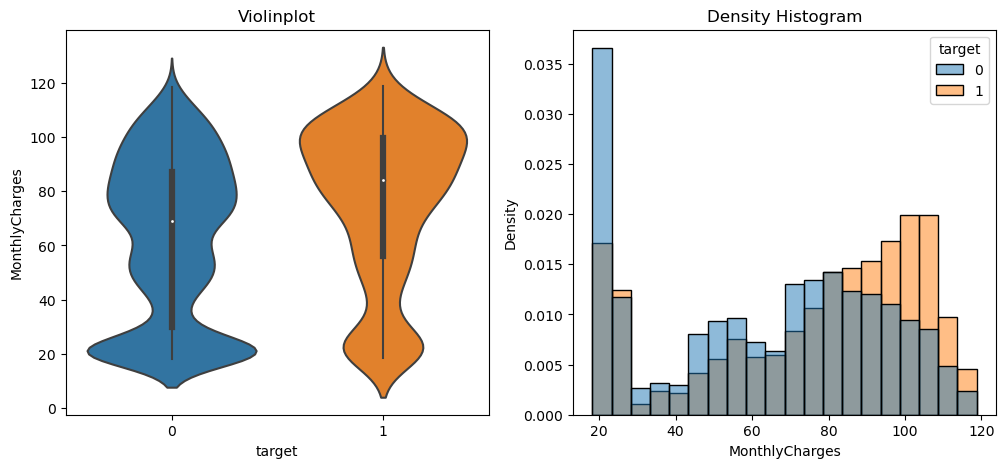

t-критерий Стьюдента
p-значение: 8.951756508949511e-39
Выборки различимы


In [48]:
violinplot_denshist_ttest(data, 'MonthlyCharges', 'target')

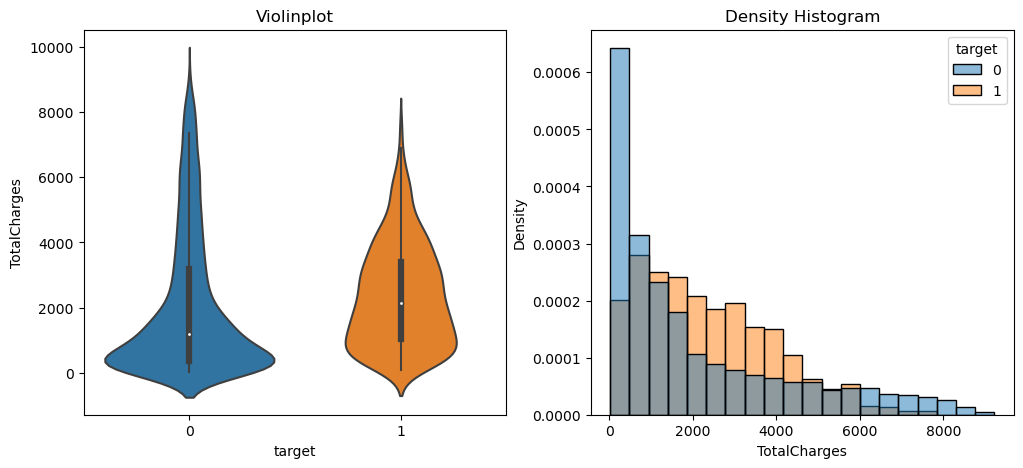

t-критерий Стьюдента
p-значение: 1.1874770533475489e-05
Выборки различимы


In [49]:
violinplot_denshist_ttest(data, 'TotalCharges', 'target')

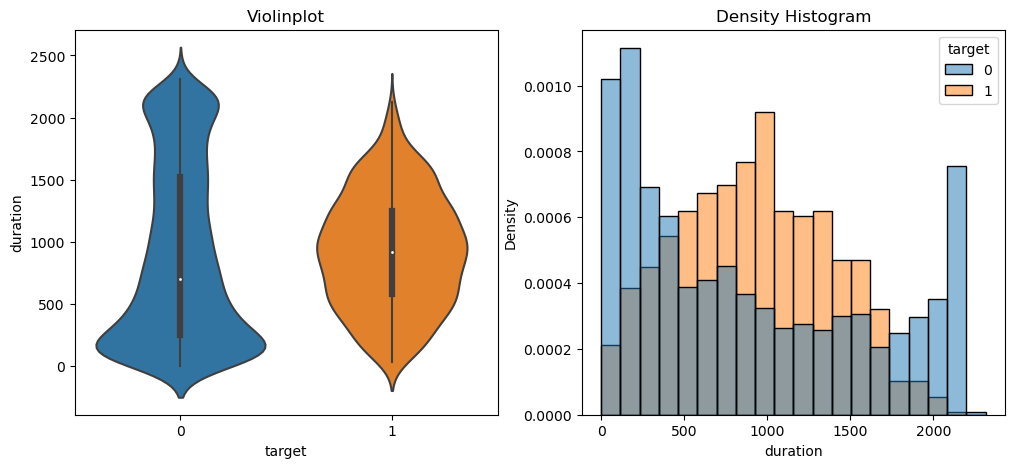

t-критерий Стьюдента
p-значение: 0.1641794881643094
Выборки не различимы


In [50]:
violinplot_denshist_ttest(data, 'duration', 'target')

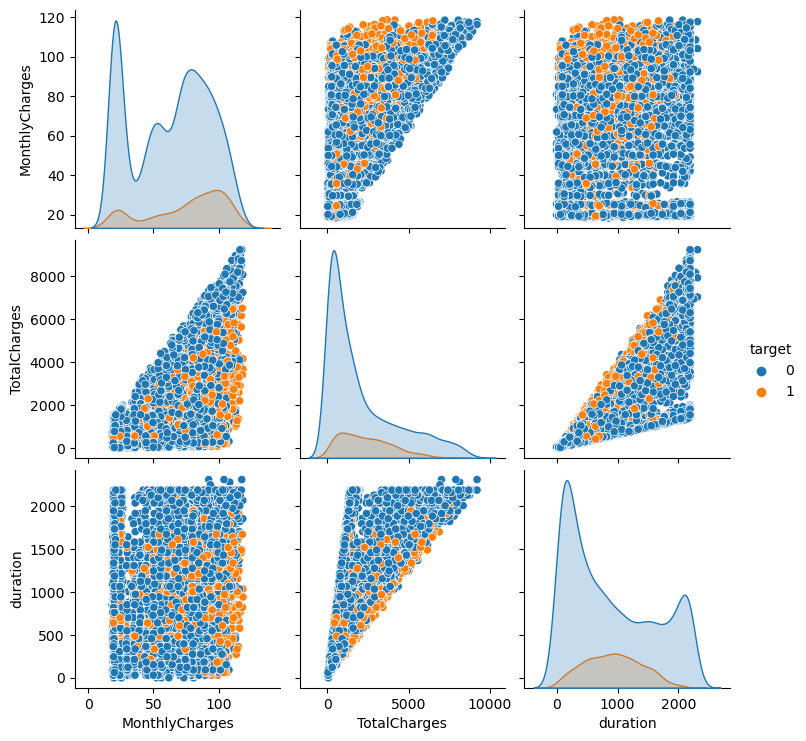

In [51]:
num_features = ['MonthlyCharges', 'TotalCharges', 'duration', 'target']
ax = sns.pairplot(data[num_features], hue='target')

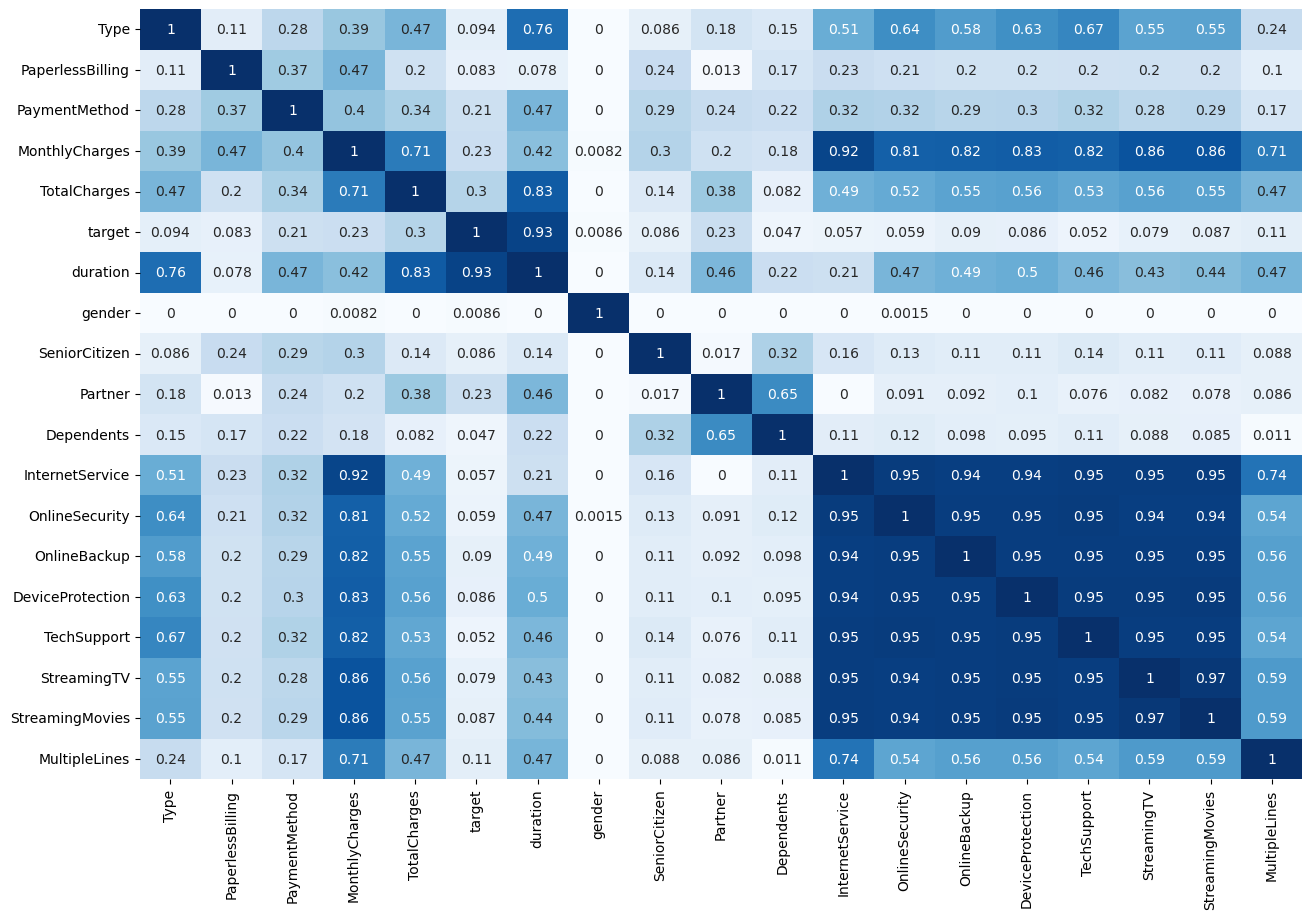

In [52]:
plt.figure (figsize=(15,10))
interval_cols = ['MonthlyCharges', 'TotalCharges' ,'contract']
sns.heatmap (df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='Blues', cbar=False);

С целевым признаком больше всех коррелирует новый признак длительность договора duration

Заметна коррелляция у MonthlyCharges (ежемесячные траты на услуги) и TotalCharges (всего потрачено денег на услуги) с различными дополнительными услугами, что вполне логично, есть траты на доп.услуги – есть зависимость

Заметна сильная зависимость между MonthlyCharges (ежемесячные траты на услуги) и InternetService

In [53]:
def plot_pies( df: pd.DataFrame, feature: str, target: str, *, rows_num: Optional[int] = None, cols_num: Optional[int] = None,) -> None:
    """
    Визуализирует распределение значений категориального признака в виде круговой диаграммы.

    Args:
        df: DataFrame, из которого будет вытаскиваться распределение.
        feature: признак, для которого визуализируется распределение ответов.
        target: название столбца с целевой переменной.
        rows_num: количество строчек на рисунке.
        cols_num: количество столбцов на рисунке.
    """
    df = df[[feature, target]].copy()

    has_na = df[feature].isna().any()  # флаг наличия пропусков
    # формируем отсортированный список значений признака
    if has_na:
        values = sorted(df.dropna()[feature].unique())
    else:
        values = sorted(df[feature].unique())
    # формируем отсортированный список меток
    labels = sorted(df[target].unique())

    if rows_num is None or cols_num is None:
        rows_num = 1
        cols_num = len(labels) + 1

    fig, axes = plt.subplots(rows_num, cols_num, figsize=(24, 5))
    axes = axes.flat
    fig.suptitle(feature, fontsize=16)

    for label, ax in zip(labels, axes[:len(labels)]):
        ax.set_title(label)
        label_df = df[df[target] == label]
        sizes = [(label_df[feature] == value).sum() for value in values]
        if has_na:
            na_num = label_df[feature].isna().sum()
            sizes.append(na_num)
        ax.pie(sizes, autopct='%1.1f%%')

    axes[-1].set_title('Весь датасет')
    sizes = [(df[feature] == value).sum() for value in values]
    if has_na:
        na_num = df[feature].isna().sum()
        sizes.append(na_num)
        values.append('NaN')
    wedges, _, _ = axes[-1].pie(sizes, autopct='%1.1f%%')
    axes[-1].legend(wedges, values, bbox_to_anchor=(1, 0, 0.5, 1))

    plt.show()

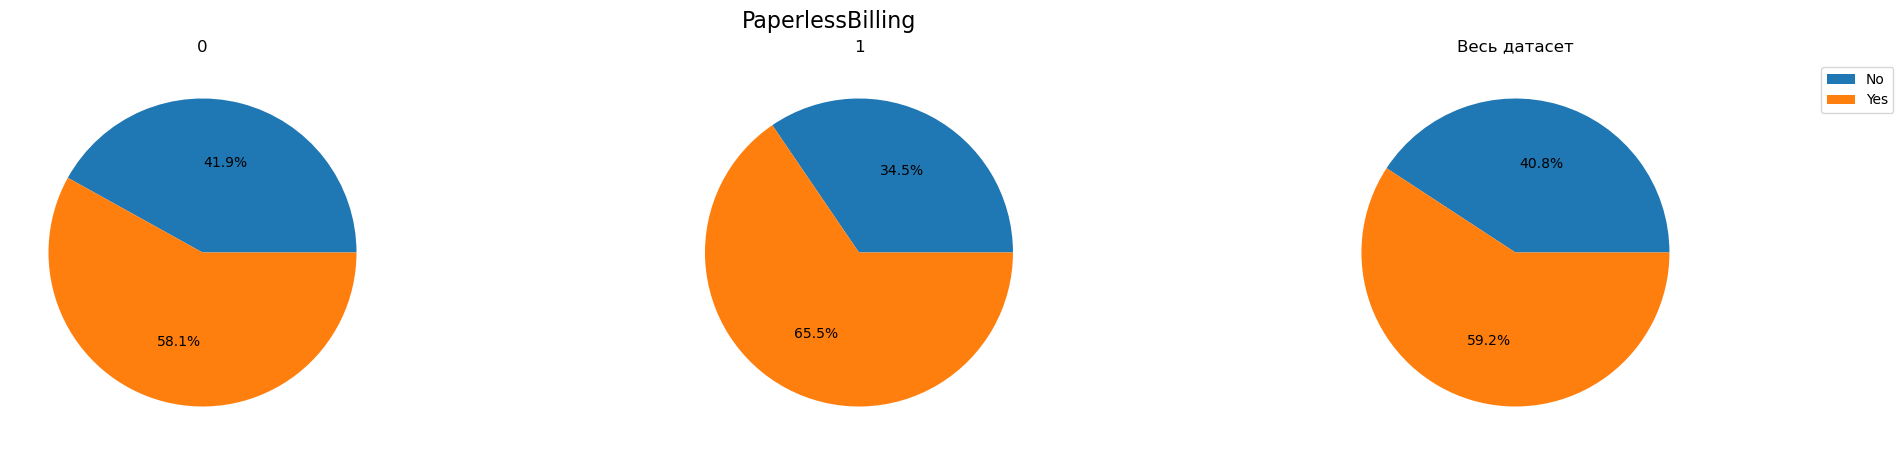

In [54]:
plot_pies(data, 'PaperlessBilling', 'target')

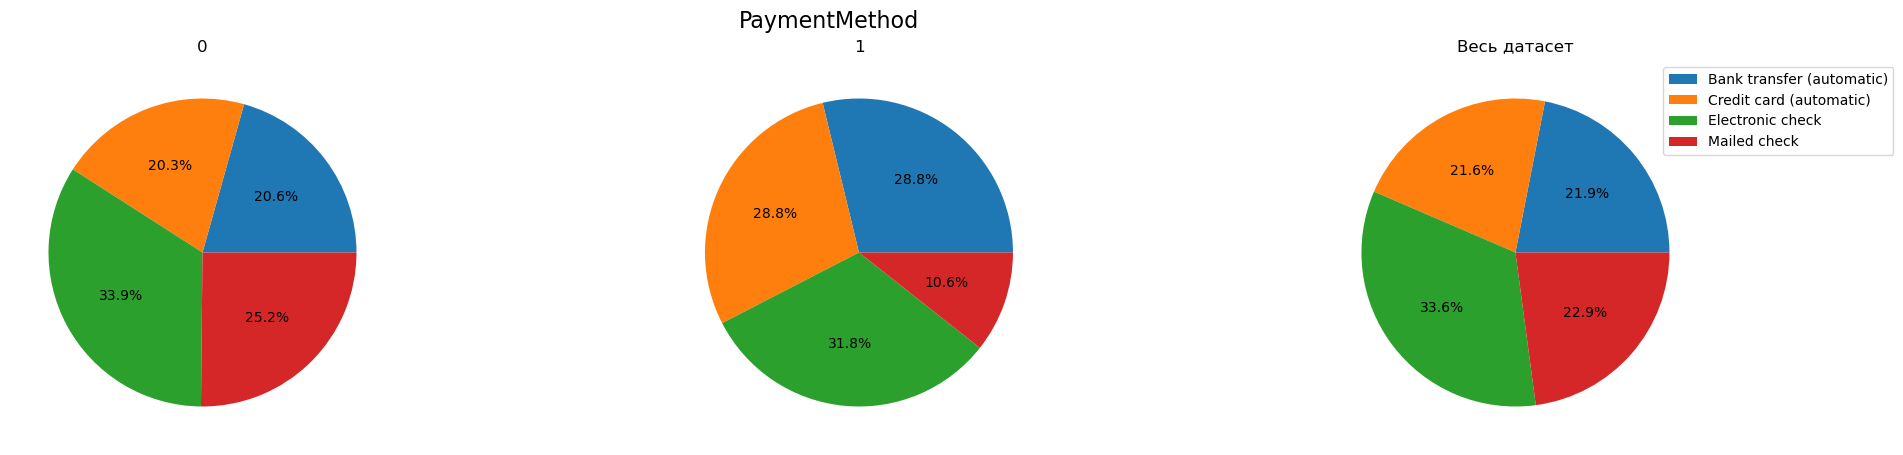

In [55]:
plot_pies(data, 'PaymentMethod', 'target')

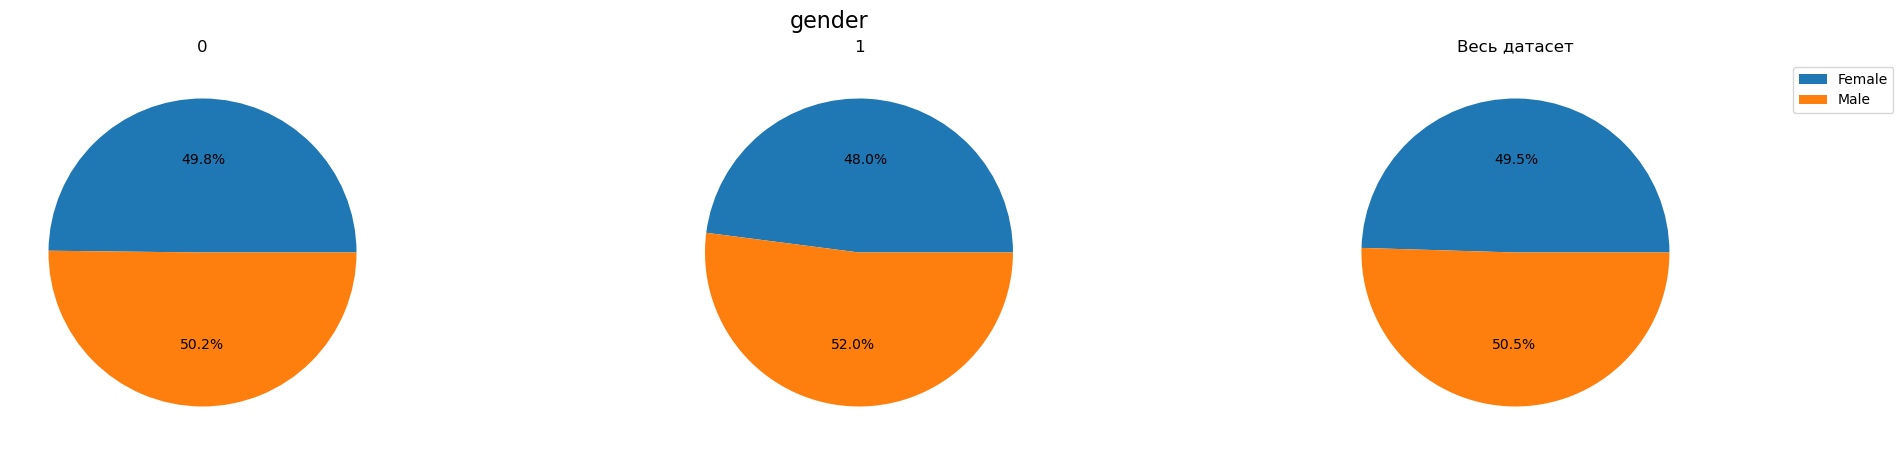

In [56]:
plot_pies(data, 'gender', 'target')

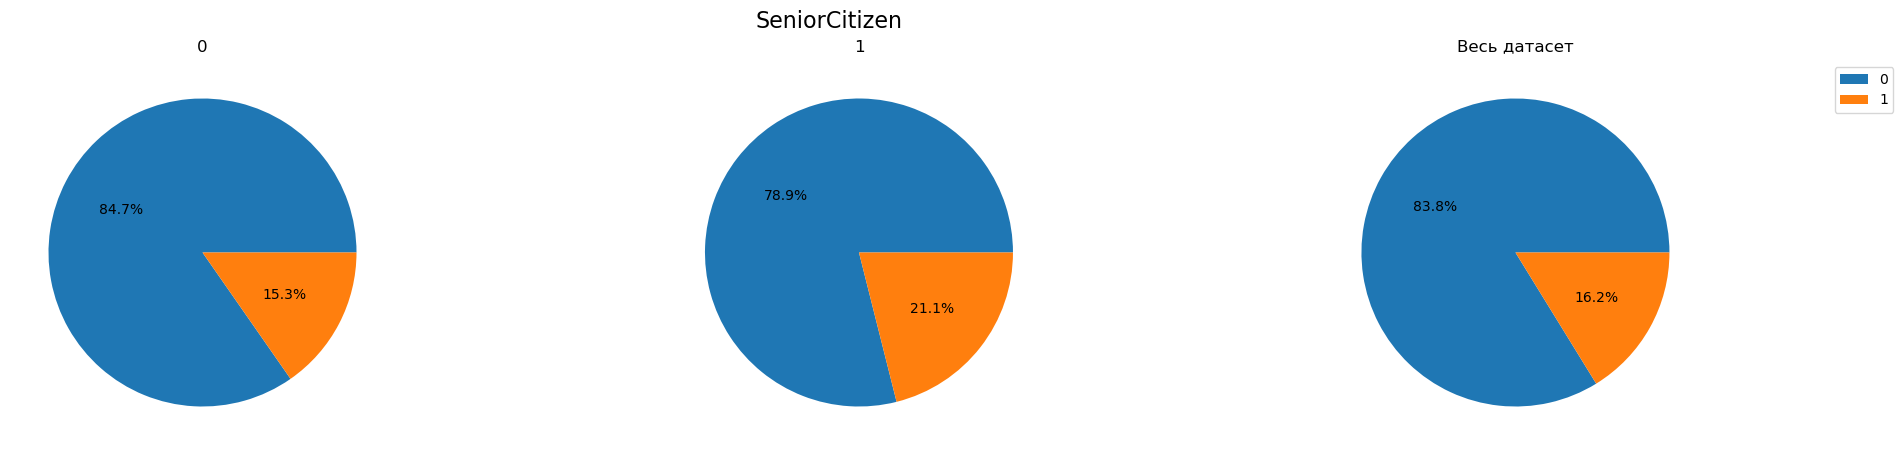

In [57]:
plot_pies(data, 'SeniorCitizen', 'target')

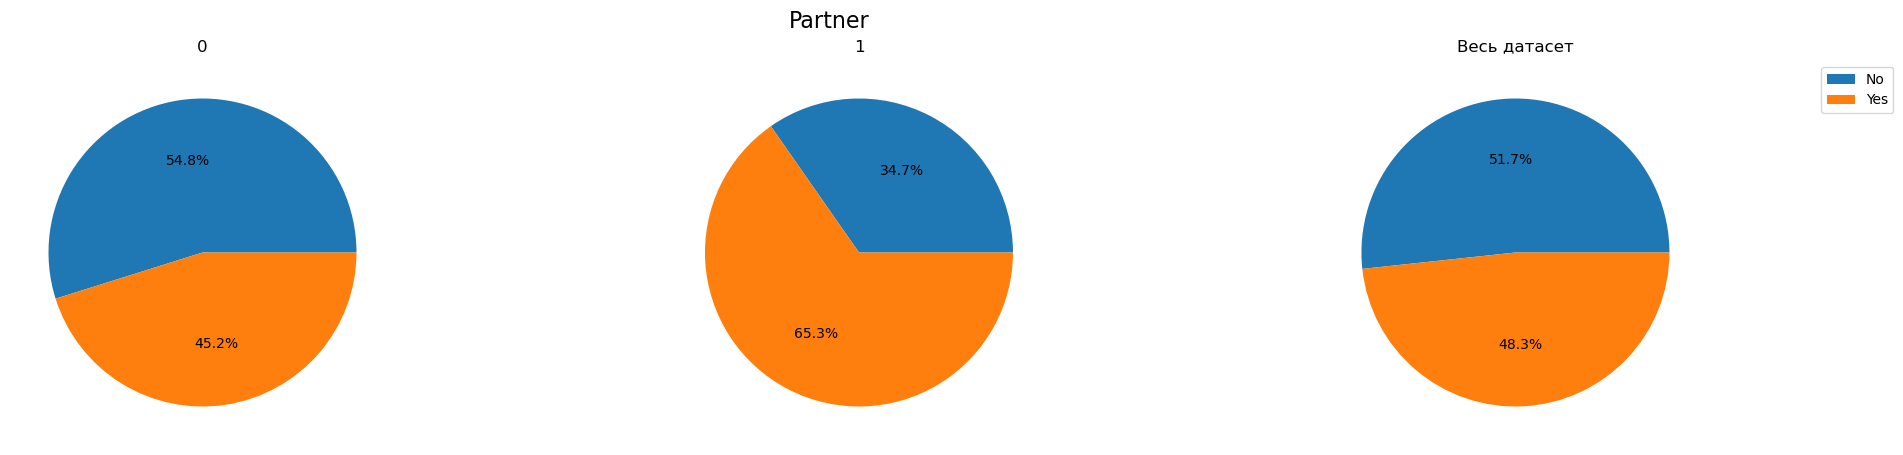

In [58]:
plot_pies(data, 'Partner', 'target')

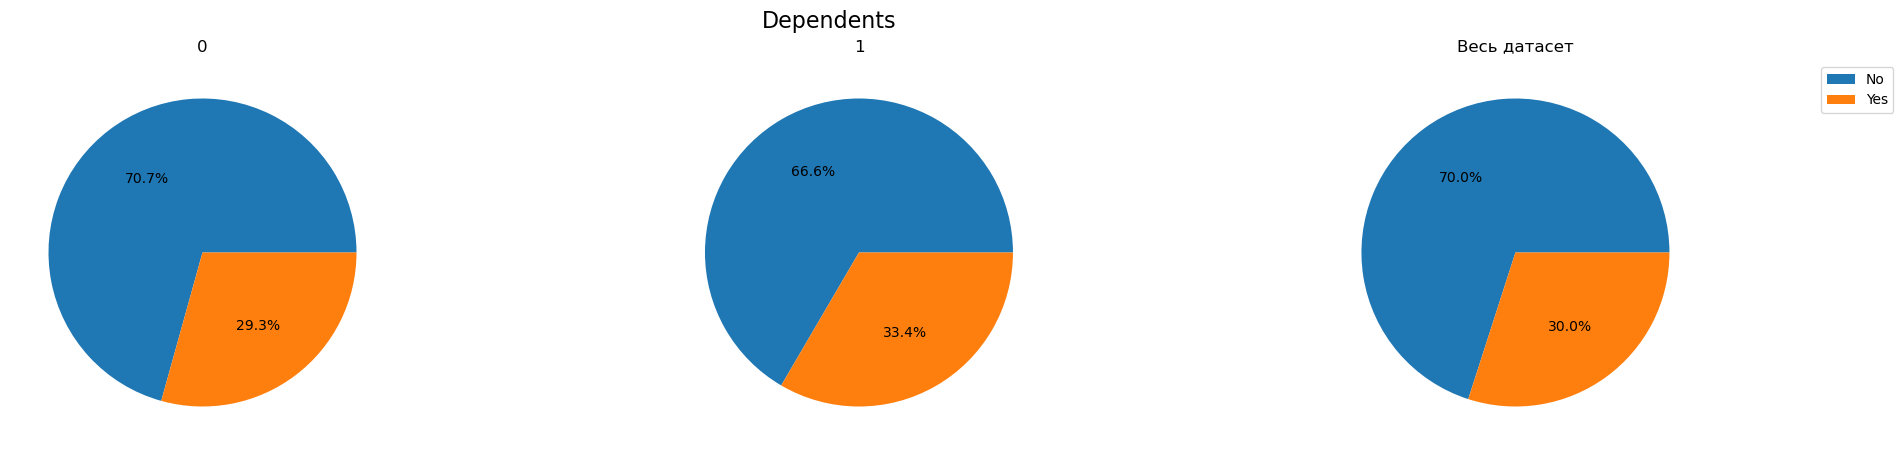

In [59]:
plot_pies(data, 'Dependents', 'target')

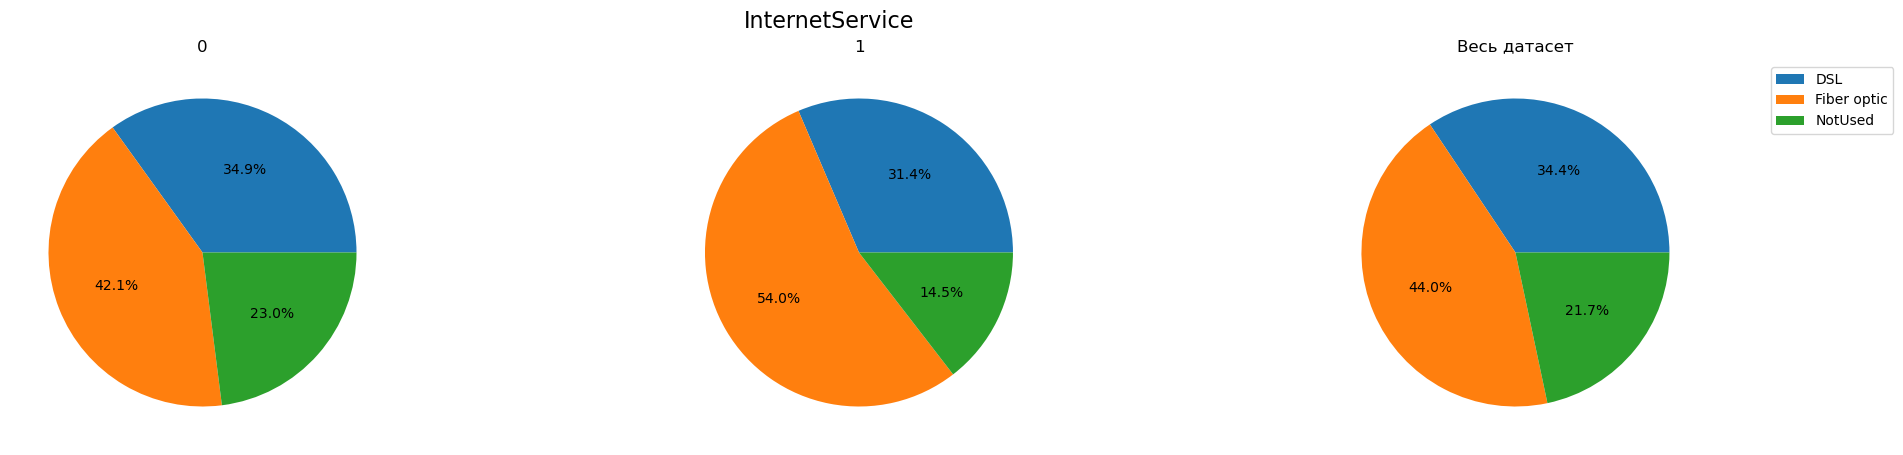

In [60]:
plot_pies(data, 'InternetService', 'target')

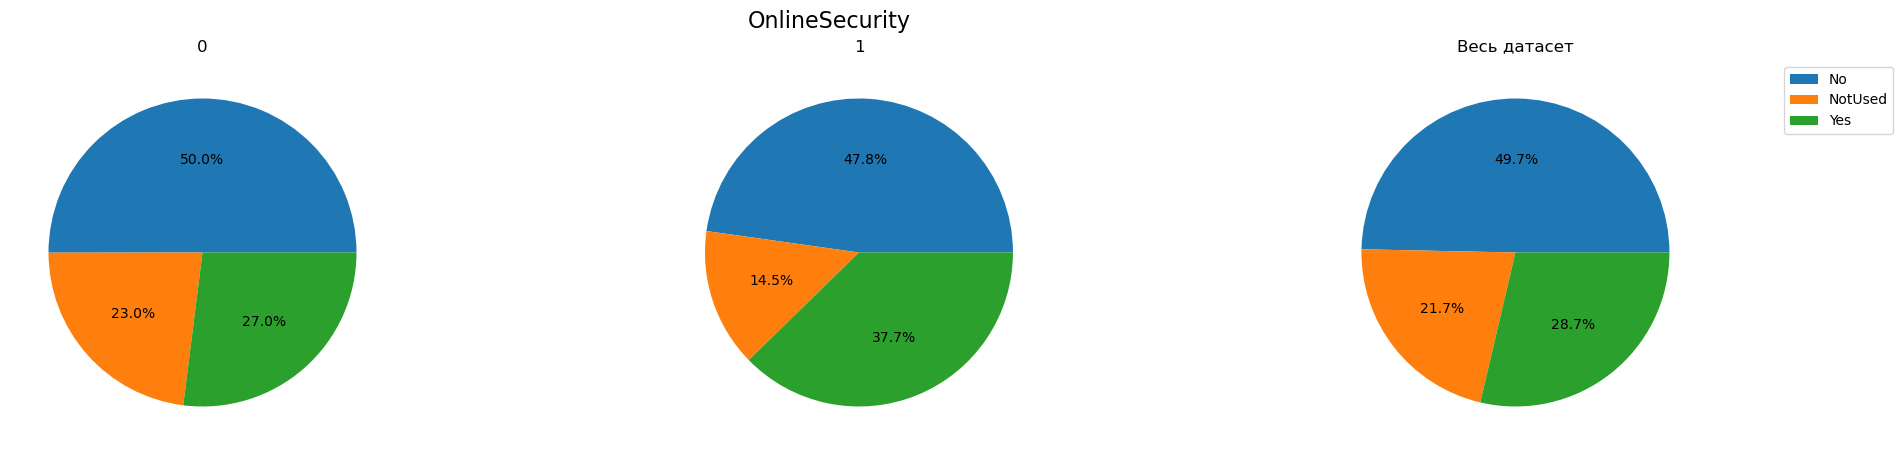

In [61]:
plot_pies(data, 'OnlineSecurity', 'target')

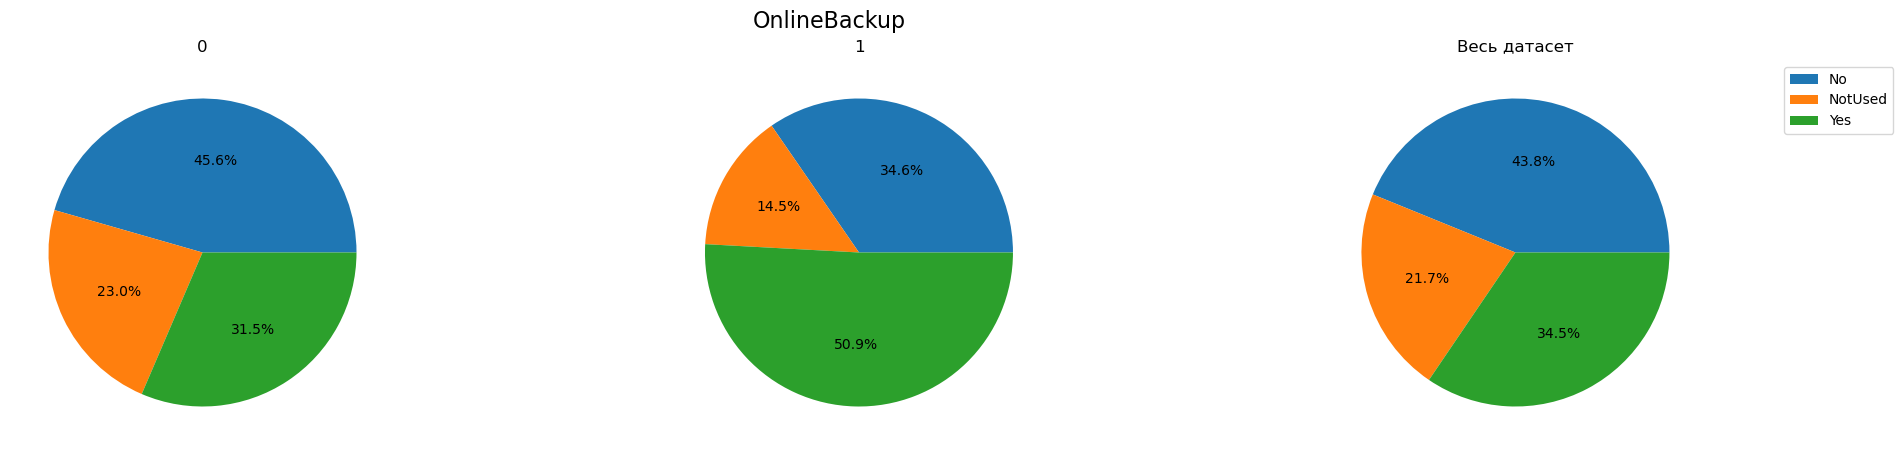

In [62]:
plot_pies(data, 'OnlineBackup', 'target')

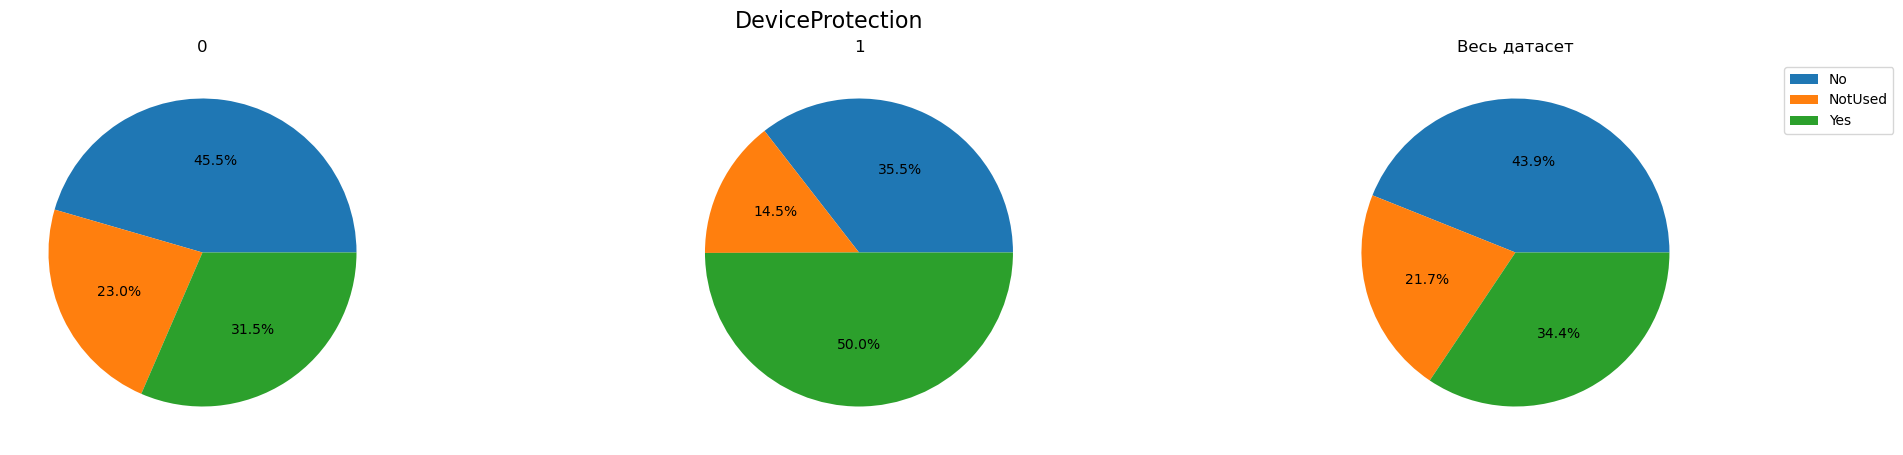

In [63]:
plot_pies(data, 'DeviceProtection', 'target')

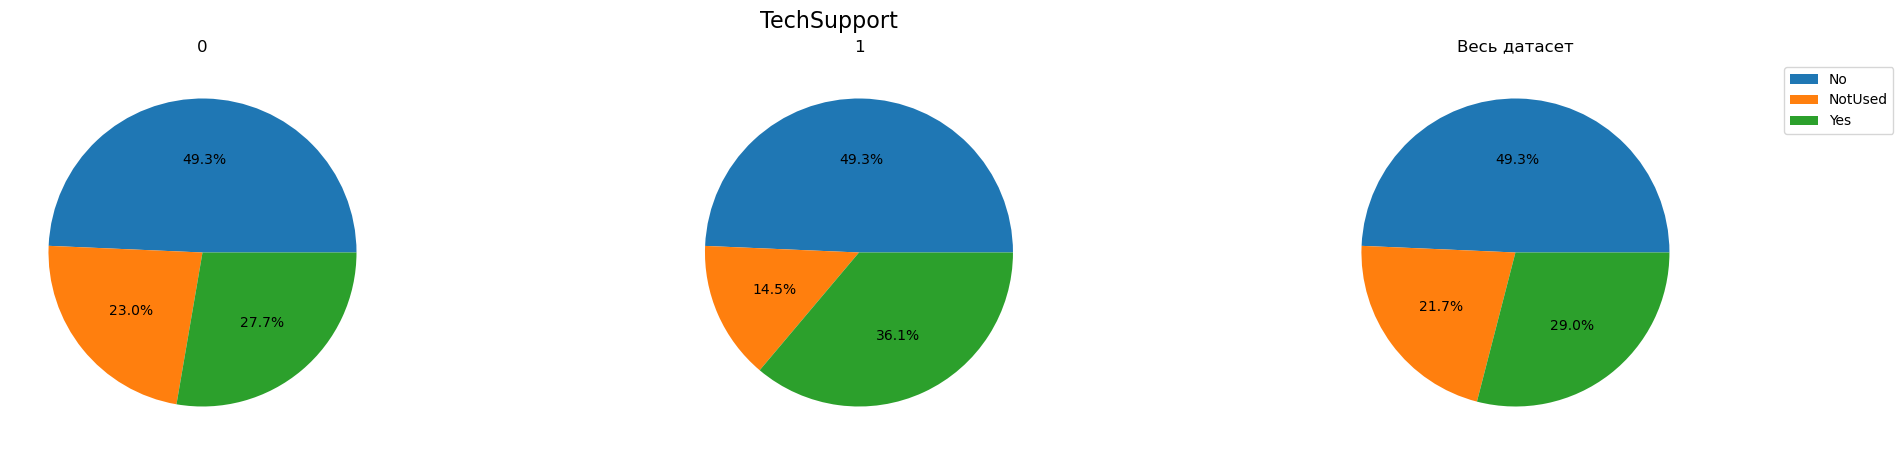

In [64]:
plot_pies(data, 'TechSupport', 'target')

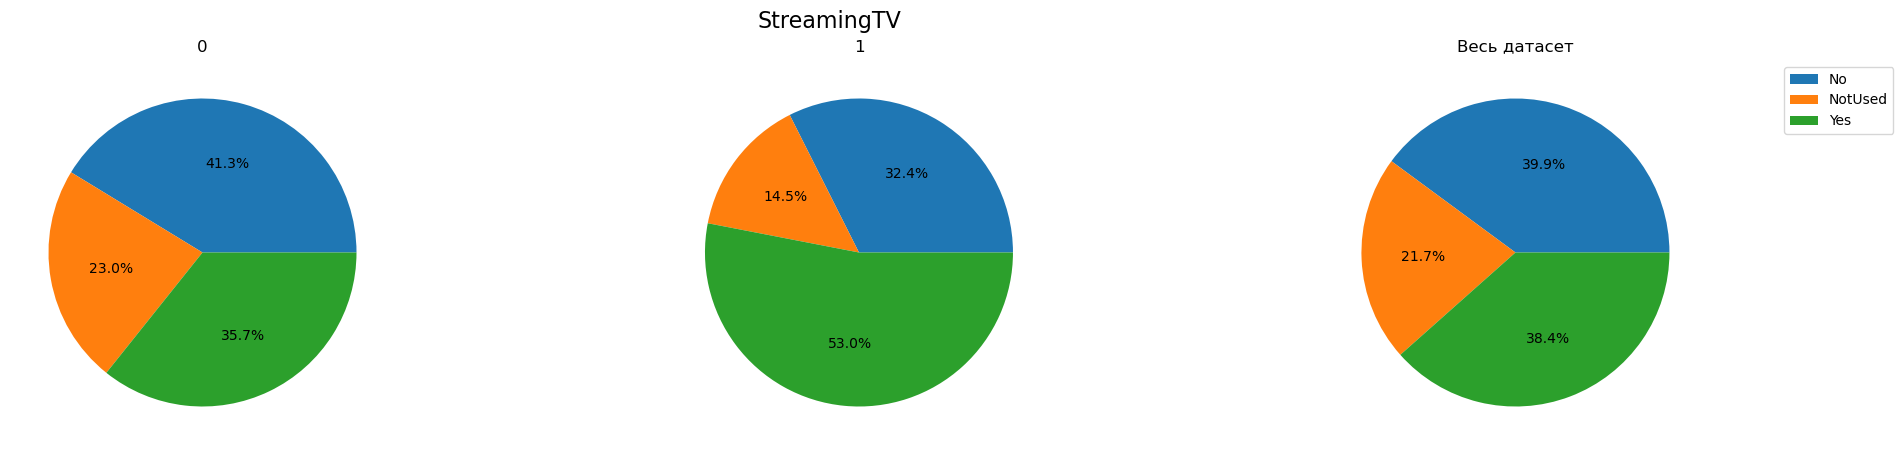

In [65]:
plot_pies(data, 'StreamingTV', 'target')

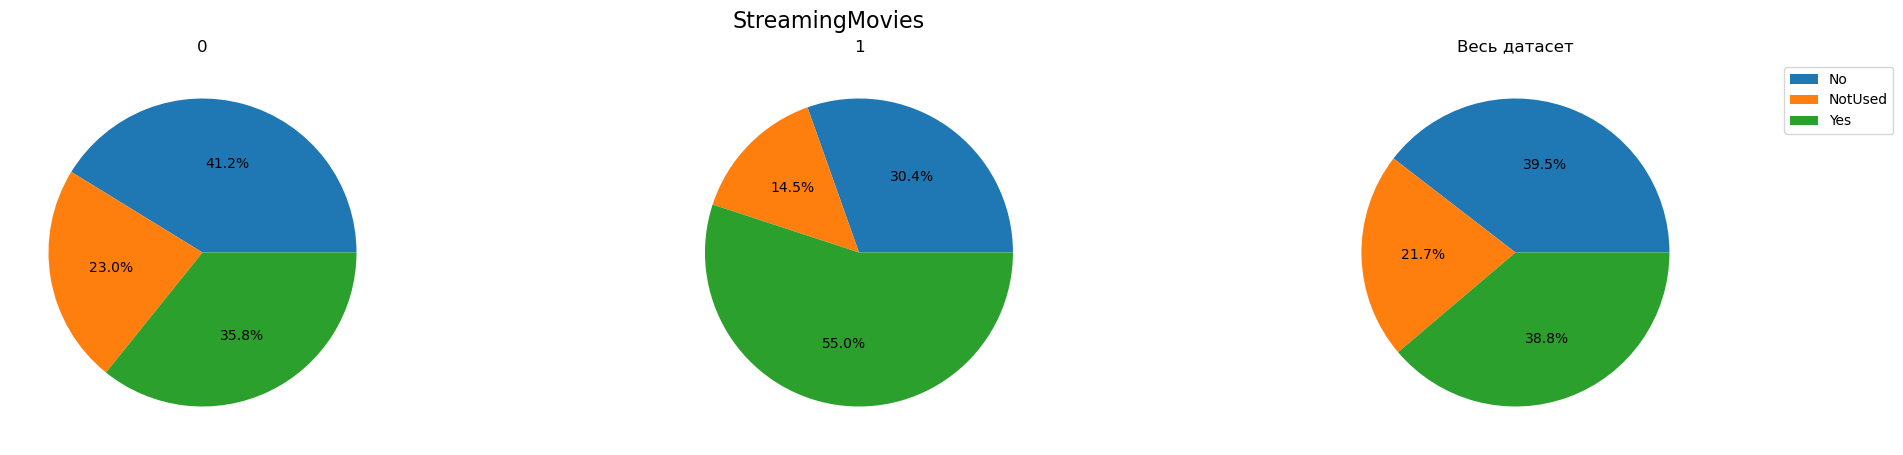

In [66]:
plot_pies(data, 'StreamingMovies', 'target')

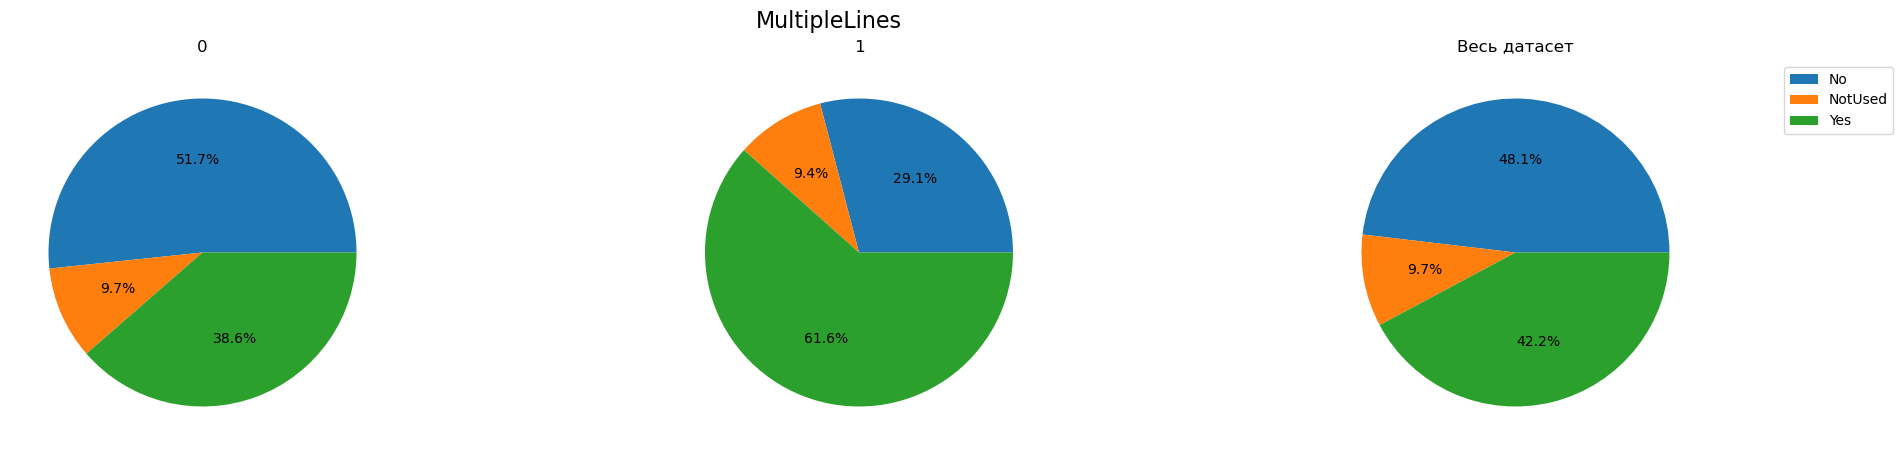

In [67]:
plot_pies(data, 'MultipleLines', 'target')

__Вывод:__

- Количество клиентов, прекращающих пользоваться услугами, приблизительно в три раза меньше, чем тех, кто продолжает оставаться на связи.
- Распределение ежемесячных расходов у клиентов, покидающих компанию, значительно смещено в сторону более высоких значений по сравнению с оставшимися.
- Когда клиент решает уйти, это обычно происходит в первые месяцы пользования услугами.
- У клиентов, покидающих компанию, чаще возникает потребность в получении счетов на электронную почту.
- Клиенты, покидающие компанию, также чаще предпочитают оплачивать свои счета с помощью электронных чеков.
- Среди тех, кто прекращает пользоваться услугами, пенсионеров встречается в два раза больше.
- Среди уходящих клиентов те, у кого есть домашние животные, также встречаются в два раза чаще.
- Если клиент, который покидает компанию, решает подключить интернет, то вероятнее всего, он выбирает подключение через оптоволокно.
- Уходящие клиенты, в основном, отказываются от дополнительных услуг для интернета.

## План


- **Этап 1**: Построение модели прогнозирования оттока.
 - Выбор алгоритма машинного обучения.
 - Разделение данных на тренировочный и тестовый наборы.
 - Обучение модели на тренировочных данных.
- **Этап 2**: Оценка и интерпретация результатов.
 - Расчёт метрик AUC-ROC и Accuracy.
 - Определение оптимального порогового значения для AUC-ROC.
 - Анализ важности признаков для модели.
 - Анализ матрицы ошибок для оценки производительности модели.
 - Интерпретация метрик и результатов модели.
- **Этап 3**: Подготовка отчёта.
 - Составление текстового отчёта с выводами.

<div>
<h2> КОД <a class="tocSkip"> </h2>
</div>

#### Разделение данных на тренировочный и тестовый наборы.

In [68]:
X = data.drop(columns='target')
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE,
)

### Выбор алгоритма машинного обучения

#### LightGBM

In [69]:
def objective(trial):
    lgbm_model = lightgbm.LGBMClassifier(
        objective='binary',
        boosting_type=trial.suggest_categorical('boosting_type', ['dart', 'gbdt', 'rf']),
        subsample=trial.suggest_float('subsample', .05, 1.,),
        subsample_freq=trial.suggest_int('subsample_freq', 2, 4),
        n_estimators=trial.suggest_int('n_estimators', 10, 300),
        learning_rate=trial.suggest_float('learning_rate', .05, 1., log=True),
        num_leaves=trial.suggest_int('num_leaves', 2, 16),
        max_depth=trial.suggest_int('max_depth', 1, 8),
        colsample_bytree=trial.suggest_float('colsample_bytree', .05, 1.),
        reg_alpha=trial.suggest_float('reg_alpha', .5, 5),
        reg_lambda=trial.suggest_float('reg_lambda', .5, 5),
        is_unbalance=True,
        random_state=RANDOM_STATE,
    )

    sss = StratifiedShuffleSplit(n_splits=5, test_size=.25, random_state=RANDOM_STATE)
    auc_scores = np.zeros(5)
    for i, (t, v) in enumerate(sss.split(X_train, y_train)):
        train_X = X_train.iloc[t]
        train_y = y_train.iloc[t]

        val_X = X_train.iloc[v]
        val_y = y_train.iloc[v]

        lgbm_model.fit(train_X, train_y)
        y_proba = lgbm_model.predict_proba(val_X)[:, 1]
        auc_scores[i] = roc_auc_score(val_y, y_proba)

    return auc_scores.mean()

### Обучение модели на тренировочных данных c расчётом метрик AUC-ROC

In [70]:
study = optuna.create_study(direction='maximize', study_name='lgbm_optuna')

In [71]:
%%time
study.optimize(objective, n_trials=100, n_jobs=-1)

CPU times: total: 5min 59s
Wall time: 30.6 s


In [72]:
trial = study.best_trial
print('Лучшие гиперпараметры:')
for param, value in trial.params.items():
    print(f'* {param}: {value}')
print(f'Лучший AUC: {trial.value}')

Лучшие гиперпараметры:
* boosting_type: gbdt
* subsample: 0.9428740238344449
* subsample_freq: 2
* n_estimators: 277
* learning_rate: 0.11418296776350874
* num_leaves: 11
* max_depth: 7
* colsample_bytree: 0.5467289043527949
* reg_alpha: 0.6920436168456126
* reg_lambda: 4.080168778892477
Лучший AUC: 0.8726459032602192


#### CatBoost

In [73]:
def objective(trial):

    catboost_model = catboost.CatBoostClassifier(
        subsample=trial.suggest_float('subsample', .05, 1.,),
        n_estimators=trial.suggest_int('n_estimators', 10, 300),
        learning_rate=trial.suggest_float('learning_rate', .05, 1., log=True),
        max_depth=trial.suggest_int('max_depth', 1, 8),
        reg_lambda=trial.suggest_float('reg_lambda', .5, 5),
        auto_class_weights='Balanced',
        verbose=0,
        random_state=RANDOM_STATE,
    )

    sss = StratifiedShuffleSplit(n_splits=5, test_size=.25, random_state=RANDOM_STATE)
    auc_scores = np.zeros(5)
    for i, (t, v) in enumerate(sss.split(X_train, y_train)):
        train_X = X_train.iloc[t]
        train_y = y_train.iloc[t]

        val_X = X_train.iloc[v]
        val_y = y_train.iloc[v]

        catboost_model.fit(train_X, train_y, cat_features=train_X.select_dtypes('category').columns.to_list())
        y_proba = catboost_model.predict_proba(val_X)[:, 1]
        auc_scores[i] = roc_auc_score(val_y, y_proba)

    return auc_scores.mean()

### Обучение модели на тренировочных данных c расчётом метрик AUC-ROC

In [74]:
study = optuna.create_study(direction='maximize', study_name='catboost_optuna')

In [75]:
%%time

study.optimize(objective, n_trials=100, n_jobs=-1)

CPU times: total: 1h 2min 1s
Wall time: 4min 35s


In [76]:
trial = study.best_trial
print('Лучшие гиперпараметры:')
for param, value in trial.params.items():
    print(f'* {param}: {value}')
print(f'Лучший AUC: {trial.value}')

Лучшие гиперпараметры:
* subsample: 0.6748611344035044
* n_estimators: 300
* learning_rate: 0.6248017062889001
* max_depth: 2
* reg_lambda: 0.5360013424708345
Лучший AUC: 0.920011448494783


## Линейная модель

In [77]:
to_encode = ['Type',
             'PaperlessBilling',
             'PaymentMethod',
             'InternetService',
             'OnlineSecurity',
             'OnlineBackup',
             'DeviceProtection',
             'TechSupport',
             'StreamingTV',
             'StreamingMovies',
             'Partner',
             'Dependents',
             'MultipleLines', 'SeniorCitizen', 'gender']

In [78]:
features_train_ohe = X_train.copy()
ohe = OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output=False)
ohe.fit(features_train_ohe[to_encode])
features_train_ohe[ohe.get_feature_names_out()] = ohe.transform(features_train_ohe[to_encode])
features_train_ohe = features_train_ohe.drop(features_train_ohe[to_encode], axis=1)

In [79]:
%%time
model_regression = LogisticRegression(random_state=70823)
param_grid = {'max_iter': [100, 200, 300, 500, 1000],
              'solver': ['newton-cg'],
              'multi_class':['ovr','multinomial']}


CPU times: total: 0 ns
Wall time: 0 ns


In [80]:
grid_search_regression = GridSearchCV(model_regression, param_grid=param_grid, cv=5,scoring='roc_auc')

In [81]:
grid_search_regression.fit(features_train_ohe, y_train)

The line search algorithm did not converge
The line search algorithm did not converge
newton-cg failed to converge. Increase the number of iterations.
The line search algorithm did not converge
The line search algorithm did not converge
newton-cg failed to converge. Increase the number of iterations.
newton-cg failed to converge. Increase the number of iterations.
newton-cg failed to converge. Increase the number of iterations.
The line search algorithm did not converge
The line search algorithm did not converge
newton-cg failed to converge. Increase the number of iterations.
The line search algorithm did not converge
The line search algorithm did not converge
newton-cg failed to converge. Increase the number of iterations.
The line search algorithm did not converge
The line search algorithm did not converge
newton-cg failed to converge. Increase the number of iterations.
The line search algorithm did not converge
The line search algorithm did not converge
newton-cg failed to converge.

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=70823),
             param_grid={'max_iter': [100, 200, 300, 500, 1000],
                         'multi_class': ['ovr', 'multinomial'],
                         'solver': ['newton-cg']},
             scoring='roc_auc')

In [82]:
grid_search_regression.best_score_

0.7694755410065899

In [83]:
grid_search_regression.best_params_

{'max_iter': 200, 'multi_class': 'multinomial', 'solver': 'newton-cg'}

### Случайный лес

In [84]:
label = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [85]:
features_train_ord = X_train.copy()
features_train_ord[to_encode] = label.fit_transform(X_train[to_encode])


In [86]:
%%time
model_forest = RandomForestClassifier(random_state=70823)
param_grid_forest = {'max_depth': [2,3,4,5,6],
                     'n_estimators':[10,15,25,50],
                     'criterion': ['gini','entropy'],
                     'min_samples_leaf': [3,4,5,6]}

CPU times: total: 0 ns
Wall time: 0 ns


In [87]:
grid_search_forest = GridSearchCV(model_forest, param_grid=param_grid_forest, cv=5, scoring='roc_auc')
grid_search_forest.fit(features_train_ord, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=70823),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [3, 4, 5, 6],
                         'n_estimators': [10, 15, 25, 50]},
             scoring='roc_auc')

In [88]:
grid_search_forest.best_score_

0.8292558835663936

In [89]:
grid_search_forest.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 3,
 'n_estimators': 50}

### Тестирование

In [90]:
catboost_model = catboost.CatBoostClassifier(
    subsample=trial.params['subsample'],
    n_estimators=trial.params['n_estimators'],
    learning_rate=trial.params['learning_rate'],
    max_depth=trial.params['max_depth'],
    reg_lambda=trial.params['reg_lambda'],
    auto_class_weights='Balanced',
    verbose=0,
    random_state=RANDOM_STATE,
)
catboost_model = catboost_model.fit(X_train, y_train, cat_features=X_train.select_dtypes('category').columns.to_list())

### Анализ матрицы ошибок для оценки производительности модели

In [91]:
y_pred = catboost_model.predict(X_test)
y_proba = catboost_model.predict_proba(X_test)[:, 1]

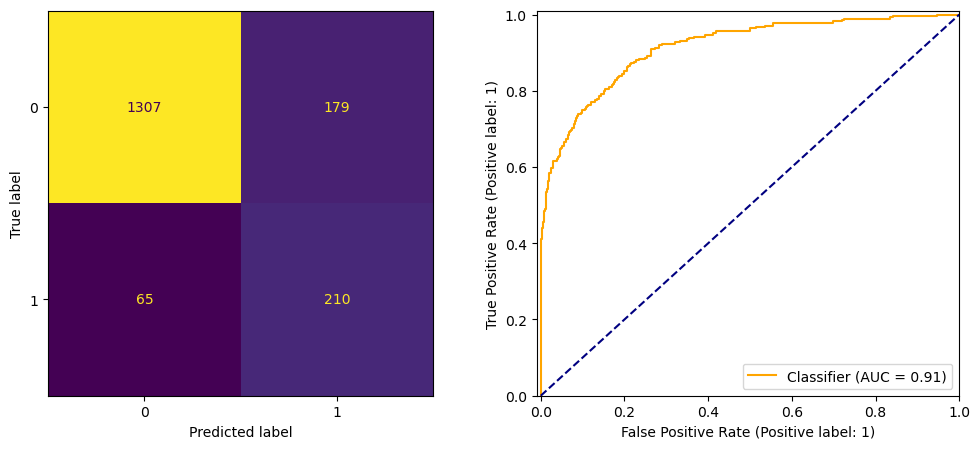

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1486
           1       0.54      0.76      0.63       275

    accuracy                           0.86      1761
   macro avg       0.75      0.82      0.77      1761
weighted avg       0.89      0.86      0.87      1761



In [92]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    ax=axes[0],
    colorbar=False,
)

RocCurveDisplay.from_predictions(
    y_test, y_proba,
    ax=axes[1],
    color='orange',
)
axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[1].set_ylim(0, 1.01)
axes[1].set_xlim(-0.01, 1)

plt.show()

print(classification_report(y_test, y_pred))

In [93]:
auc_roc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)

print(f"AUC-ROC: {auc_roc}")
print(f"Accuracy: {accuracy:.2f}")

AUC-ROC: 0.9138455891349566
Accuracy: 0.86


### Анализ важности признаков для модели

In [94]:
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


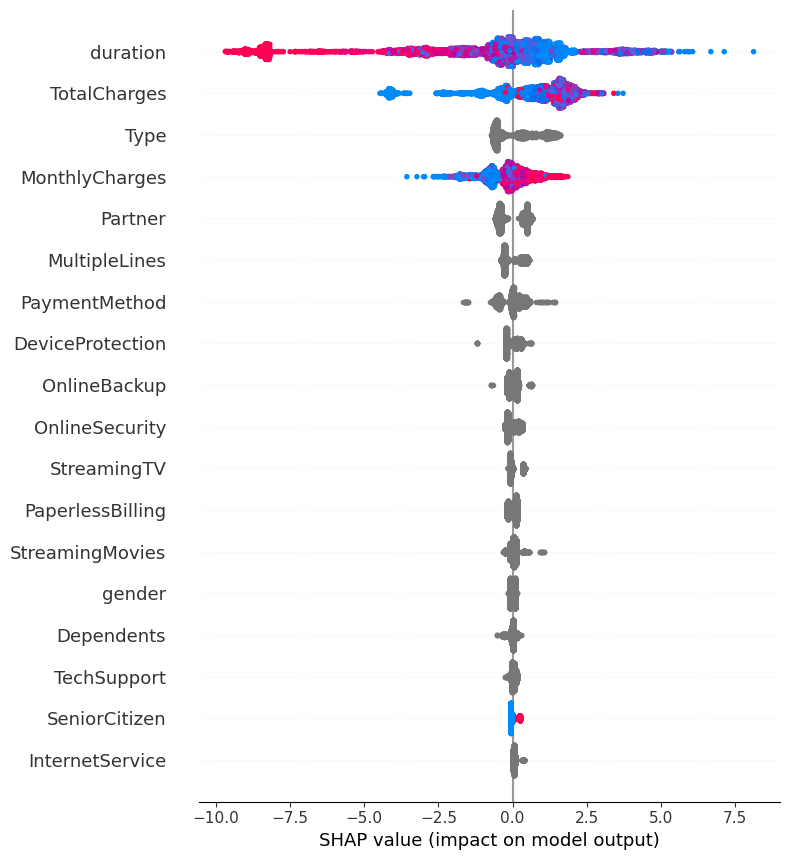

In [95]:
shap.summary_plot(
    shap_values=shap_values,
    features=X,
    color_bar=False,
)

Наибольшее влияние на модель оказывает характеристика под названием "продолжительность". Кроме того, следует подчеркнуть важность четырех последующих характеристик: "Тип", "Ежемесячные платежи", "Общие платежи" и "Онлайн-безопасность". Прочие характеристики оказывают менее заметное влияние на модель.

## Общий вывод

- Мы исключили из датасета образцы, для которых невозможно было определить целевой признак.
- Был создан новый параметр, который отражает продолжительность контракта. Все остальные параметры, за исключением дат, были использованы.
- В процессе перекрестной проверки мы выбрали модель градиентного бустинга CatBoost с определенными гиперпараметрами (subsample: 0.9641994294202554, n_estimators: 274, learning_rate: 0.4869238373003475, max_depth: 2, reg_lambda: 3.249280777391674). По результатам тестирования на тестовых данных данная модель продемонстрировала значения AUC = 0.91 и accuracy = 0.84.

- Порядок значимости признаков для обучения следующий:

 * duration (новый атрибут)
 * TotalCharges
 * Type
 * MonthlyCharges
 * Partner
 * MultipleLines
 * PaymentMethod
 * OnlineBackup
 * PaperlessBilling
 * StreamingMovies
 * OnlineSecurity
 * DeviceProtection
 * TechSupport
 * gender
 * SeniorSitizen
 * StreamingTV
 * InternetService
 * Dependents


- Для всех категориальных атрибутов пропущенные значения были заменены на "NotUsed".

- Обобщенная таблица всех моделей и их показатели на этапе перекрестной проверки.

| Модель                 | AUC-ROC           |
|------------------------|--------------------|
| LightGBM               | 0.875849313523968 |
| CatBoost               | 0.9120638513777222 |
| LogisticRegression     | 0.7694755410065899 |
| RandomForestClassifier | 0.8292558835663936 |

<div>
<h2> Отчет <a class="tocSkip"> </h2>
</div>

## Цель и задачи

Целью данной работы является прогнозирование оттока клиентов.

- **Этап 1**: Построение модели прогнозирования оттока.
 - Выбор алгоритма машинного обучения.
 - Разделение данных на тренировочный и тестовый наборы.
 - Обучение модели на тренировочных данных.
- **Этап 2**: Оценка и интерпретация результатов.
 - Расчёт метрик AUC-ROC и Accuracy.
 - Определение оптимального порогового значения для AUC-ROC.
 - Анализ важности признаков для модели.
 - Анализ матрицы ошибок для оценки производительности модели.
 - Интерпретация метрик и результатов модели.
- **Этап 3**: Подготовка отчёта.
 - Составление текстового отчёта с выводами.

## Анализ соответствия фактической работы запланированным шагам

Работа была выполнена в соответствии с поставленными задачами

<br>Был создан признак duration, который показывает сколько дней клиент пользовался/пользуется услугами компании.
<br>Были удалены два признака - BeginDate и EndDate.

## Итоговый список признаков для обучения модели

### Категориальные признаки, которые были использованы

Type - тип оплаты: ежемесячный, годовой и тд
<br>PaperlessBilling - электронный платёжный документ
<br>PaymentMethod - способ оплаты
<br>InternetService - тип интернет подключения
<br>OnlineSecurity - блокировка небезопасных сайтов
<br>OnlineBackup - облачное хранилище файлов для резервного копирования данных
<br>DeviceProtection - антивирус
<br>TechSupport - выделенная линия технической поддержки
<br>StreamingTV - стриминговое телевидение
<br> StreamingMovies - каталог фильмов
<br> Partner - наличие супруга(и)
<br> Dependents - наличие иждивенцев 
<br> MultipleLines - наличие возможности ведения параллельных линий во время звонка
<br> SeniorCitizen - наличие пенсионного статуса по возрасту

### Численные признаки, которые были использованы

MonthlyCharges - ежемесячные траты на услуги по договору
<br>TotalCharges - всего потрачено денег на услуги
<br>duration - количество дней, прошедших со дня заключения договора

## Краткое описание предобработки данных

В столбце TotalCharges были обнаружены несколько строк, содержащие пробелы. Это клиенты, которые пользуются услугами первый месяц и не были занесены в этот столбец.
<br> Пробелы были заменены на соответвующие значения столбца MonthlyCharges.

Также данные таблицы (contract_new.csv, personal_new.csv, internet_new.csv, phone_new.csv) были соединены в одну - data.

## Таблица исследованных моделей и их метрика на кросс-валидации

| Модель                 | AUC-ROC           |
|------------------------|--------------------|
| LightGBM               | 0.875849313523968 |
| CatBoost               | 0.9120638513777222 |
| LogisticRegression     | 0.7694755410065899 |
| RandomForestClassifier | 0.8292558835663936 |

## Лучшая модель

Лучший результат на кросс-валидации показала модель CatBoost. Ее значение ROC-AUC - 0.91.

### Гиперпараметры

Лучшие гиперпараметры:
* subsample: 0.8979385607702759
* n_estimators: 285
* learning_rate: 0.44769794654067746
* max_depth: 2
* reg_lambda: 2.562393161791487

## Итоговая метрика на test (AUC-ROC и Accuracy).

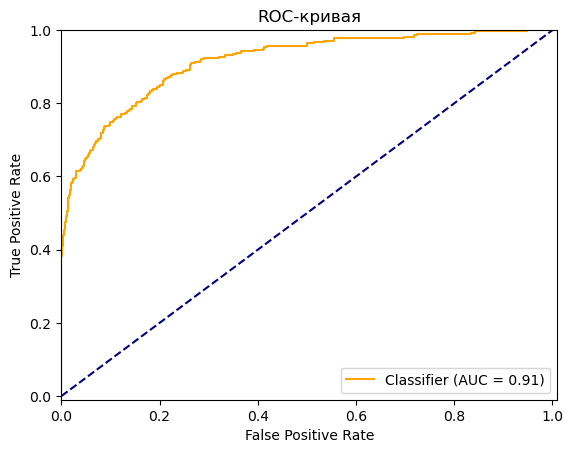

AUC-ROC: 0.9138455891349566
Accuracy: 0.86


In [107]:
RocCurveDisplay.from_predictions(
    y_test, y_proba,
    color='orange',
)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim(0, 1.01)
plt.ylim(-0.01, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")

plt.show()
auc_roc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)

print(f"AUC-ROC: {auc_roc}")
print(f"Accuracy: {accuracy:.2f}")

## Матрица ошибок

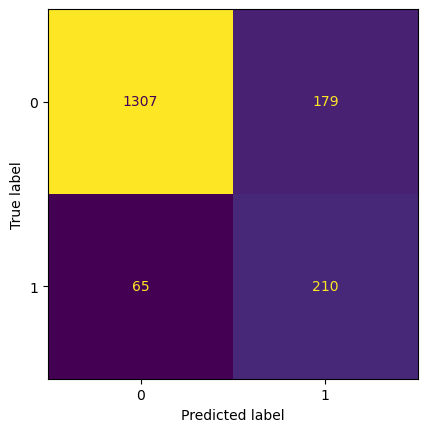

In [103]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    colorbar=False,
)

Можно заметить, что модель ошиблась 65 раз и предсказала уход клиента, когда на самом деле клиент не ушел.

Также модель 179 раза ошиблась и предсказала, что клиент останется, в то время, когда клиент ушел.

1307 раз модель верно выбрала категорию и предсказала, что клиент не ушел, что соответствует реальности.

210 раз модель верно выбрала категорию и предсказала, что клиент ушел, что также соответвует реальности.

## Важность признаков

In [98]:
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


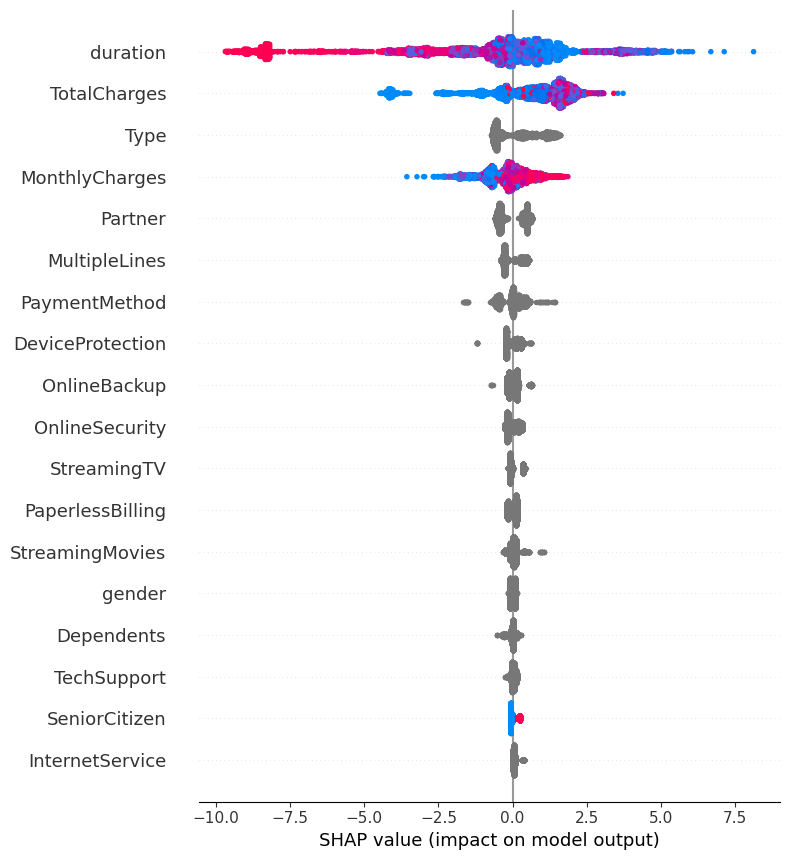

In [99]:
shap.summary_plot(
    shap_values=shap_values,
    features=X,
    color_bar=False,
)

Наибольшее влияние на модель оказывает характеристика под названием "продолжительность". Кроме того, следует подчеркнуть важность четырех последующих характеристик: "Тип", "Ежемесячные платежи", "Общие платежи" и "Онлайн-безопасность". Прочие характеристики оказывают менее заметное влияние на модель.